<a href="https://colab.research.google.com/github/GitHubOfAndrew/Transformer-Model-Prototype/blob/main/Transformer_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MOUNT DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/NLP Workbooks/Abstractive Summarization/

/content/drive/My Drive/NLP Workbooks/Abstractive Summarization


# Transformer Implementation

Here, we will attempt to implement the Transformer model of natural language processing as indicated in the paper *Attention is All You Need*: https://arxiv.org/pdf/1706.03762.pdf.

## Transformer Concepts

We have three things to note when we talk about the attention mechanism in Transformers: Query, Key, Value.

Although we will not explain in detail what the query and key and value are, it is important to note that they will be utilized in the architecture in a particular way.

The primary concept of interest in the transformer model is the idea of **attention**. And more than that, we are interested in **self-attention**. Generally speaking, self-attention determines the impact that a word will have on the sentence. 

More specifically, the self-attention mechanism works by indicating that for a certain *query* (i.e. a word in our sentence), we compare it to the *keys* (every other token surrounding query), and then we compute the attention between these two quantities. This computed attention is the *value*, from which we will compute the multi-head attention by comparing it with the *keys* again.

### Positional Encoding

As attention mechanisms have no idea of the ordering of certain tokens in a sentences, we will use a positional encoding to capture the order.

$$\mathrm{PE}_{pos, even\;dim} = \sin\left(pos/10000^{2i/d_{model}}\right)$$

$$\mathrm{PE}_{pos, odd\;dim} = \cos\left(pos/10000^{2i/d_{model}}\right)$$

### Padding Mask

Since the input vector of sequences is fixed in length, we specify a maximum length, and then for any sequences that do not meet the maximum length, we just pad it with zeros.

### Look-Ahead Mask

A look-ahead mask ensures that target sequences generated in the decoder only have each token contributing to the next token. We incorporate the masked multi-head attention to perform this.

### Scaled Dot Product Attention

We have the query ($Q$), key ($K$), value ($V$). What we will do is the following:

$$A(Q,K,V) = \mathrm{softmax}\left(\frac{Q\cdot K^{T}}{\sqrt{d_{k}}}\right)\cdot V$$

In order to verify that the dimensionality of this is correct, we just look at it.

For an input sequence of size $m$, and for words with a max length of $n$,

### Multi-Head Attention

Here we encapsulate everything we mentioned before. We perform $h$ scaled dot product attention mechanisms, and each will have a query, key, value. For max length of words of $n$, $m$ length sequences, the dimensions of the query, key, value are all computed according to the following:

$$\mathrm{depth} = d_{model} // h$$

For each of the $h$ dot product attentions, we have that $d_{model}$ shaped vectors are passed as $h$ separate query, key, value to the attention, and then we concatenate them together after the mechanism to return to the original $d_{model}$ shaped vector.

### Regularization and Dense Layers

These are typical of neural networks in order to facilitate learning and to prevent overfitting. This is not interesting in practical use, but just helpful. Our transformer architecture visual is in the paper linked above. We will attempt to recreate it here.

# Implementation in TensorFlow

We will be performing **abstractive summarization** here. This is the more meaningful way to summarize in general as it implies that the model understands the context of the text as opposed to just parsing through it.

## Dataset

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import timeit as t

In [ ]:
news_df = pd.read_excel('Inshorts Cleaned Data.xlsx')

news_df

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25
...,...,...,...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the...",The Financial Express,10:36:00,2016-01-20
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...,Reuters,12:06:00,2016-01-20
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...,Hindustan Times,12:10:00,2016-01-20
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...,YouTube,11:53:00,2016-01-20


In [ ]:
news_df.columns


Index(['Headline', 'Short', 'Source ', 'Time ', 'Publish Date'], dtype='object')

In [ ]:
news_df = news_df.drop(columns=['Source ', 'Time ', 'Publish Date'])

news_df.shape

(55104, 2)

In [ ]:
# split into our input and our label

document = news_df['Short']
summary = news_df['Headline']

In [ ]:
document.shape

(55104,)

In [ ]:
summary.shape

(55104,)

In [ ]:
document[1], summary[1]

('Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect all the records electronically from the lower courts and the high courts so that there is no need to file hard copies.',
 'Supreme Court to go paperless in 6 months: CJI')

## Preprocess for Input

**Remember:** the encoder takes inputs, the decoder takes targets!

In [ ]:
# decoder sequence

summary = summary.apply(lambda x: '<go> ' + x + ' <stop>')

summary.head()

0    <go> 4 ex-bank officials booked for cheating b...
1    <go> Supreme Court to go paperless in 6 months...
2    <go> At least 3 killed, 30 injured in blast in...
3    <go> Why has Reliance been barred from trading...
4    <go> Was stopped from entering my own studio a...
Name: Headline, dtype: object

### Tokenization

Convert our text sequences into vectors.

In [ ]:
filter_chars = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

# for unknown tokenizations
oov_token = '<unk>'

In [ ]:
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)

summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filter_chars)

In [ ]:
# fit our tokenizers for our respective data

document_tokenizer.fit_on_texts(document)

summary_tokenizer.fit_on_texts(summary)

In [ ]:
# now convert our input document into sequences
# likewise for our target

inputs = document_tokenizer.texts_to_sequences(document)

targets = summary_tokenizer.texts_to_sequences(summary)

In [ ]:
# compare texts and tokenizations of them

document[0]

'The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.'

In [ ]:
# the tokenization of the first entry

inputs[0]

[2,
 1153,
 9,
 116,
 1912,
 152,
 109,
 171,
 6,
 11881,
 180,
 8,
 209,
 326,
 12,
 3907,
 17737,
 1467,
 3712,
 8,
 1913,
 28258,
 55,
 735,
 3,
 2,
 61,
 295,
 180,
 2,
 236,
 35,
 11882,
 242,
 1626,
 8,
 1809,
 20,
 11881,
 180,
 9,
 2,
 1452,
 6,
 7463,
 8,
 13762,
 1504,
 293,
 863,
 39,
 17738,
 3738,
 3,
 2,
 458,
 914,
 17,
 2,
 236,
 1712]

To ensure that our tokenization worked, let's just convert the sequence into the text

In [ ]:
document_tokenizer.sequences_to_texts(inputs)[0]

'the cbi on saturday booked four former officials of syndicate bank and six others for cheating forgery criminal conspiracy and causing ₹209 crore loss to the state run bank the accused had availed home loans and credit from syndicate bank on the basis of forged and fabricated documents these funds were fraudulently transferred to the companies owned by the accused persons'

We see here that this tokenization worked, and that the tokenizer actually lowercases everything as a default.

In [ ]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1

decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab sizes

encoder_vocab_size, decoder_vocab_size

(76362, 29660)

**We will visualize the distribution of word lengths**

In [ ]:
doc_lengths = [len(x) for x in document]

document_lengths = pd.Series(doc_lengths)

sum_lengths = [len(x) for x in summary]

summary_lengths = pd.Series(sum_lengths)

Text(0, 0.5, 'Frequency')

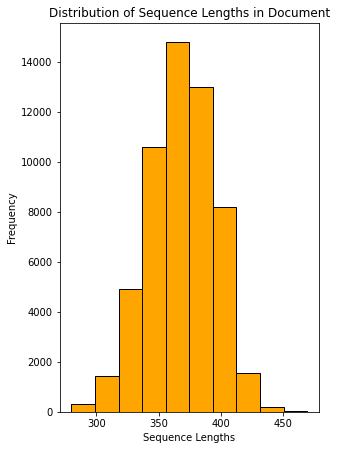

In [ ]:
# plot the sequence lengths in document

fig1 = plt.figure(figsize=(4,6))

axis1 = fig1.add_axes([0.1,0.1,0.9,0.9])

axis1.hist(doc_lengths, ec='black', color = 'orange', density=False)

axis1.set_title('Distribution of Sequence Lengths in Document')

axis1.set_xlabel('Sequence Lengths')

axis1.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

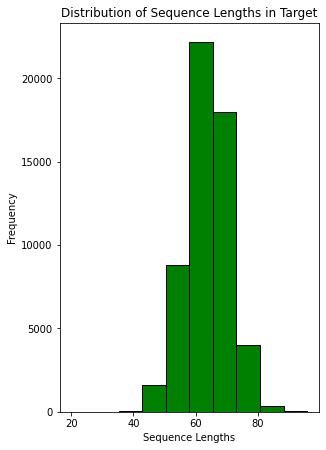

In [ ]:
# plot the sequence lengths in summary

fig2 = plt.figure(figsize=(4,6))

axis2 = fig2.add_axes([0.1,0.1,0.9,0.9])

axis2.hist(sum_lengths, ec='black', color = 'green', density=False)

axis2.set_title('Distribution of Sequence Lengths in Target')

axis2.set_xlabel('Sequence Lengths')

axis2.set_ylabel('Frequency')

In [ ]:
# descriptive statistics

document_lengths.describe()

count    55104.000000
mean       368.003049
std         26.235510
min        280.000000
25%        350.000000
50%        369.000000
75%        387.000000
max        469.000000
dtype: float64

In [ ]:
summary_lengths.describe()

count    55104.000000
mean        63.620282
std          7.267463
min         20.000000
25%         59.000000
50%         63.000000
75%         69.000000
max         96.000000
dtype: float64

We now have a range to round up to for the padding mask. We will go a little bit past the 75th percentile in order to set the max length of the padding.

In [ ]:
# encoder_maxlen is the maximum length of the 
encoder_maxlen, decoder_maxlen = 400, 75

### Padding Mask

In [ ]:
# pad inputs (encoder) and targets (decoder)

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')

targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

In [ ]:
buffer_size = 20000
batch_size = 64

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(buffer_size).batch(batch_size)


## Positional Encoding

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2*(i // 2)) / np.float32(d_model))
    return position * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    
    # apply sin to even indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

- Padding mask to mask padded sequences

- Lookahead mask for masking future words from contributing to the prediction of current words in self attention

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(size):
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

## Building the Model

We will build the attention layers that we indicated above.

### Scaled Dot Product

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # dot product attention formula
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

### Multi-Headed Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # the d_model must be divisible by heads
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm = [0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm = [0,2,1,3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        
        return output, attention_weights

## Feedforward

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

## Encoder/Decoder

We will build the encoder layers and decoder layers here, then we will build the transformer by just setting the multi-head attention layers, feedforward layers, and encoder/decoder layers in the order that is given in the paper.

### Encoder Unit

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        # first step of encoder unit
        self.mha = MultiHeadAttention(d_model, num_heads)
        
        # third step of encoder unit
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        # second step of encoder unit
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # fourth step of encoder unit
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # dropouts go before each layer normalization step
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x,x,x,mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

### Decoder Unit

Recall that this is the one that takes in the target sequences, and gets fed the encoder unit's output midway through.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        fnn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2
    

## Encoder

This is a layer that consists of multiple encoders. This is the pipeline that includes the embedding layer, positional encoding, and the encoder units.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x

## Decoder

Decoder consisting of multiple decoder units. In particular, this will be a pipeline containing the embedding, positional encoding, and the decoder units.

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
        return x, attention_weights

## Transformer

We will now encapsulate all of the objects we've built into the transformer model.

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

## Training Parameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
epochs = 25

## Optimizer with Learning Rate Scheduler

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    

In [ ]:
# NOTE: we can also try a fixed learning rate

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


## Loss

In [ ]:
# loss function

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_fn(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

## Create Transformer Instance

In [ ]:
transformer = Transformer(
    num_layers,
    d_model,
    num_heads,
    dff,
    encoder_vocab_size,
    decoder_vocab_size,
    pe_input = encoder_vocab_size,
    pe_target = decoder_vocab_size
)

### Create Mask

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask


### Checkpoints

Store checkpoints to save model at each epoch

In [ ]:
checkpoint_path = 'checkpoints'

# checkpoint object to store model instances at each epoch
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer,)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('latest checkpoint restored')

latest checkpoint restored


## Custom Training Loop

In [ ]:
# function to run one training loop

@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # get gradient tape object to perform backpropagation
    with tf.GradientTape() as tp:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    # apply gradient descent / optimization
    gradients = tp.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # take the mean of all losses
    train_loss(loss)

In [ ]:
print(f'We are training for {epochs} epochs.')

We are training for 25 epochs.


In [ ]:
for epoch in range(epochs):
    start = t.default_timer()
    
    train_loss.reset_states()
    
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
        
        if batch % 429 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.3f} Time taken for this batch {t.default_timer() - start} secs')
            
    if (epoch + 1) % 5 == 0:
        ckpt_savePath = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_savePath}')
        
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.3f}')
    
    print(f'Time taken for 1 epoch: {t.default_timer() - start} secs\n')
    

Epoch 1 Batch 0 Loss 2.780 Time taken for this batch 14.214954758000005 secs
Epoch 1 Batch 429 Loss 2.770 Time taken for this batch 181.114481155 secs
Epoch 1 Batch 858 Loss 2.794 Time taken for this batch 350.683370717 secs
Epoch 1 Loss 2.794
Time taken for 1 epoch: 351.47584898 secs

Epoch 2 Batch 0 Loss 2.817 Time taken for this batch 0.490016321999974 secs
Epoch 2 Batch 429 Loss 2.675 Time taken for this batch 169.98427917600003 secs
Epoch 2 Batch 858 Loss 2.696 Time taken for this batch 339.597651536 secs
Epoch 2 Loss 2.696
Time taken for 1 epoch: 340.388792948 secs

Epoch 3 Batch 0 Loss 2.684 Time taken for this batch 0.45856736700000056 secs
Epoch 3 Batch 429 Loss 2.580 Time taken for this batch 170.04653835200008 secs
Epoch 3 Batch 858 Loss 2.612 Time taken for this batch 339.59125223600006 secs
Epoch 3 Loss 2.612
Time taken for 1 epoch: 340.3852629280001 secs

Epoch 4 Batch 0 Loss 2.357 Time taken for this batch 0.46077263699999094 secs
Epoch 4 Batch 429 Loss 2.489 Time taken 

## Inferencing

We will now evaluate our trained model.

In [ ]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)
    
    decoder_input = [summary_tokenizer.word_index['<go>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        
        predictions, attention_weights = transformer(encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if predicted_id == summary_tokenizer.word_index['<stop>']:
            return tf.squeeze(output, axis=0), attention_weights
        
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0), attention_weights

Now perform our summarization on a sample news headline.

In [ ]:
def summarize(input_document):
    
    summarized = evaluate(input_document=input_document)[0].numpy()
    
    summarized = np.expand_dims(summarized[1:], 0)
    return summary_tokenizer.sequences_to_texts(summarized)[0]


In [ ]:
# headline from this article: https://www.nytimes.com/2022/05/01/us/new-mexico-wildfire.html

test_doc = 'High winds in northern New Mexico on Sunday once again posed a stiff challenge to crews battling a large wildfire that grew significantly over the weekend.'

summarize(test_doc)

'mexico sets up x street ice over 39 batman 39 set'

That was a goofy prediction, let us try a headline that was in our data.

In [ ]:
news_df['Headline'][2], news_df['Short'][2]

('At least 3 killed, 30 injured in blast in Sylhet, Bangladesh',
 'At least three people were killed, including a policeman, while 30 others were wounded on Saturday evening in two explosions in Sylhet, Bangladesh. The explosions were targetted at people and police officials who were witnessing an over 30-hour-long gunfight between extremists and commandos. Earlier on Friday, a man had blown himself up in front of a checkpoint near Dhaka Airport.')

In [ ]:
summarize(news_df['Short'][2])

'at least 30 killed as suicide attack across india'

In [ ]:
summarize(news_df['Short'][4444])

'officials ask for 6k amid cross border defeat'

In [ ]:
news_df['Headline'][4444]

'Stamping of hand baggage stopped at seven Indian airports'

In [ ]:
summarize('Elon Musk buys Twitter for 40 bn dollars.')

'man utd open for 1 mn twitter trip report'